# Interface
The interface consists of the following modules. `homotopy.py` defines `HomotopyTrack`:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# %load homotopy.py
from typing import Tuple
import numpy as np
import scipy

class HomotopyTrack:
    """The Homotopy Track Interface

       A homotopy track consists of a homotopy function and the interval on
       which parameter continuation should take place. The homotopy parameter
       is not supplied to the methods separately and the last component of the
       `point` parameter is interpreted as the homotopy parameter.
    """

    def initial_point(self) -> np.ndarray:
        """Return the initial point on the continuation track."""
        raise NotImplementedError

    def tangent(self, point: np.ndarray) -> np.ndarray:
        """Return the tangent vector of the continuation track at `point`.

        The tangent should be a unit vector in the kernel of the gradient map.
        The direction of the tangent indicates the direction of continuation.
        """
        raise NotImplementedError

    def homotopy(self, point: np.ndarray) -> np.ndarray:
        """Return the value of homotopy at `point`."""
        raise NotImplementedError

    def gradient(self, point: np.ndarray) -> np.ndarray:
        """Return the value of the gradient map of the homotopy at `point`.

        Consistent with the convention that the last component of `point` is
        interpreted as the homotopy parameter, the last column of the matrix
        representing the gradient map corresponds to the partial derivatives
        with respect to the homotopy parameter.
        """
        raise NotImplementedError

    @property
    def param_range(self) -> Tuple[float, float]:
        """2-tuple indicating the interval of continuation"""
        raise NotImplementedError


The `HomotopyTrack` class is used to indicate homotopy problem to be solved. On the other hand, `preditor_corrector.py` contains a general description of the predictor-corrector continuation methods and an implementation of the Euler-Newton curve tracing method:

In [3]:
# %load predictor_corrector.py
import numpy as np

from homotopy import HomotopyTrack
from stepadj import StepAdjuster
from convergence import HomotopyConvCriterion

class PredictorCorrectorMethod:
    """A General Predictor Corrector Method"""
    def __init__(self, step_adjuster: StepAdjuster,
            trace_conv_criterion: HomotopyConvCriterion,
            corrector_conv_criterion: HomotopyConvCriterion):
        self.step_adjuster = step_adjuster
        self.trace_conv_criterion = trace_conv_criterion
        self.corrector_conv_criterion = corrector_conv_criterion

    def predict(self, track: HomotopyTrack, cur_point: np.ndarray):
        """Predict and return the next point on the homotopy track."""
        raise NotImplementedError

    def correct(self, estimate: np.ndarray, track: HomotopyTrack):
        """Correct the supplied estimate of the given point on the track.
        
        The correct method should only implement a single correction step.
        Correction steps are applied until the corrected estimate is accurate
        enough as indicated by `self.corrector_conv_criterion`, or an error is
        raised.
        """
        raise NotImplementedError

    def trace(self, track: HomotopyTrack):
        """Trace the given homotopy track and return the final point."""
        point = track.initial_point()
        self.trace_conv_criterion.reset()
        while not self.trace_conv_criterion.converged(point, track):
            estimate = self.predict(track, point)
            self.corrector_conv_criterion.reset()
            while not self.corrector_conv_criterion.converged(estimate, track):
                estimate = self.correct(estimate, track)
            point = estimate
            self.step_adjuster.adjust(track, point)
        return point

class EulerNewton(PredictorCorrectorMethod):
    def predict(self, track: HomotopyTrack, point):
        """Return the next point according to the forward Euler predictor.

        The next point is estimated using a step similar to the step used in
        the forward version of Euler's method.
        """
        return point + self.step_adjuster.cur_step_size * track.tangent(point)

    def correct(self, estimate, track: HomotopyTrack):
        """Return the correction of the estimate using a Newton correction.

        The Newton family of correctors use the current estimate as the initial
        guess in an iterative method similar to Newton's method to solve for
        the corrected point. This method uses `estimate` as the initial guess
        in one step of Newton's method and uses the pseudo-inverse of the
        gradient map in the iterate function.
        """
        J = track.gradient(estimate)
        # make sure gradient vectors are expressed as 1xn matrices.
        if len(J.shape) == 1:
            J = J.reshape(1, -1)
        return estimate - np.linalg.pinv(J) @ track.homotopy(estimate)


The predictor step uses a step similar to a forward Euler update:
$$
u^{(t + 1)} = w^{(t)}+ h \cdot t(H'(w^{(t)}))
$$
where $t(\cdot)$ denotes the tangent vector of a matrix with nullity one, $H$ is the homotopy, $u$ is the uncorrected estimate and $w$ is the corrected estimate. The notation in this document is the same as Allogower's monograph on continuation methods. The corrector step uses a Newton-Raphson update that approximates the inverse of the gradient map using the pseudo-inverse of the Jacobian matrix. The following iteration is done until $w$ is desirably close to the track:
$$
w^{(t)}_{i + 1} = w^{(t)}_i - \nabla H(w^{(t)}_i)^+ H(w^{(t)}_i) \qquad w^{(t)}_0 = u^{(t)}.
$$

For many problems, given the homotopy, the class can be populated using automatic differentiation and numeric linear algebra. `autohomotopy.py` illustrates this idea, although this class is experimental and not thoroughly tested:

In [4]:
# %load autohomotopy.py
import autograd

class AutoHomotopyTrack(HomotopyTrack):    
    def __init__(self, homotopy, init_root=None, init_param=0, final_param=1):
        self._homotopy = homotopy
        self.param_range = (init_param, final_param)
        self.init_root = init_root
        self._prev_tan = self.__init_tan()

    def initial_point(self):
        if self._init_root is None:
            raise NotImplementedError
        return np.hstack([self._init_root, self.param_range[0]])

    def tangent(self, point):
        grad = self.gradient(point) 
        tan = __ker_unit_basis(grad)
        tan *= np.sign(np.dot(tan, self._prev_tan))
        self._prev_tan = tan
        return tan

    def homotopy(self, point):
        return self._homotopy(point[:-1], point[-1])

    def gradient(self, point):
        return autograd.jacobian(self.homotopy)(point)

    def __init_tan(self):
        n = len(self.init_root) if isinstance(self.init_root, np.ndarray) else 1
        init_tan = np.zeros(n)
        init_tan[-1] = np.sign(self.param_range[1] - self.param_range[0])
        return init_tan
    
    @staticmethod
    def __ker_unit_basis(mat):
        # XXX precond: mat.shape is (n, n+1) and rank(mat) = n
        _, __, u = scipy.linalg.lu(mat)
        ker_basis = np.zeros(mat.shape[1])
        ker_basis[-1] = 1
        for i in reversed(range(mat.shape[0])):
            ker_basis[i] = -np.dot(ker_basis, u[i, :]) / u[i, i]
        ker_basis /= np.linalg.norm(ker_basis)
        return ker_basis


The predictor-corrector methods rely on helper classes that implement time-step correction and specify convergence criteria. As of now, only a trivial step controller with a constant time step is implemented, but the interface is fully defined in `stepadj.py`:

In [5]:
# %load stepadj.py
import numpy as np

class StepAdjuster:
    """A General Time-step Controller"""
    def adjust(self, track, point):
        """Adjust the time step according to the current point on the track."""
        raise NotImplementedError

    @property
    def cur_step_size(self):
        """a float giving the current time step"""
        raise NotImplementedError

class ConstantStep(StepAdjuster):
    """A Time-step Controller with a Constant Step Size"""
    def __init__(self, h=1e-2):
        self.h = h

    def adjust(self, track, point):
        pass

    @property
    def cur_step_size(self):
        return self.h


Another helper class used by the `PredictorCorrectorMethod` class is the convergence criterion as defined in `convergence.py`:

In [6]:
# %load convergence.py
import numpy as np
from homotopy import HomotopyTrack

class ConvCriterion:
    """General Convergence Criterion"""
    def converged(self, *args) -> bool:
        """Return whether convergence is achieved."""
        raise NotImplementedError

    def reset(self):
        """Reset the state of the criterion tracker.

        Convergence criterion objects hold state, e.g. the number of iterations
        so far. This method resets the state of `self` so that it can be reused.
        """
        raise NotImplementedError

class FailedToConverge(Exception):
    """Exception Indicating Failure in Convergence"""
    pass

class HomotopyConvCriterion(ConvCriterion):
    """General Convergence Criterion for Homotopy Methods"""
    def converged(self, point, track: HomotopyTrack):
        raise NotImplementedError


---
## Example
Below comes an example of how to use the code to solve for the steady state of an op-amp Schmitt trigger circuit. The script as a whole is accessible in `schmitt_trigger.py`.

First, we need to define the homotopy track. In this example the function whose zero we are trying to find is given by
$$
f(v_o) = \tanh\left(k(\frac{v_o}{2} - v_i)\right) - v_o \qquad k = 10
$$
Taking $v_o$ as our state variable and $v_i$ as our homotopy continuation parameter we can define the following homotopy:
$$
h(x, \lambda) = \tanh\left(k(\frac{x}{2} - \lambda)\right) - x \qquad k = 10.
$$
In this problem, our starting parametr is $\lambda = -0.8$ which gives an initial root that is very close to 1. The final parameter in our case is $\lambda = 0.8$. Because of choice of parameters, we make sure that the tangent vector always has a positive component corresponding to $\lambda$.

In [7]:
class SchmittTriggerHomotopyTrack(HomotopyTrack):
    def __init__(self, k=10):
        self.k = k
        self._prev_tan = np.array([0, 1])

    def initial_point(self):
        return np.array([1, -0.8])

    def final_param(self):
        return 0.8

    def tangent(self, point):
        grad = self.gradient(point)
        tan = np.array([-grad[1], grad[0]]) / np.linalg.norm(grad)
        tan *= np.sign(np.dot(self._prev_tan, tan))
        self._prev_tan = tan
        return tan

    def homotopy(self, point):
        x, lambda_ = point[:-1], point[-1]
        return self.f(x, lambda_)

    def gradient(self, point):
        x, lambda_ = point[:-1], point[-1]
        return np.array([self.df_dvo(x, lambda_), self.df_dvi(x, lambda_)]).flatten()

    def f(self, vo, vi):
        return np.tanh(self.k * (vo/2 - vi)) - vo

    def df_dvi(self, vo, vi):
        return -self.k * (1 - np.tanh(self.k * (vo/2 - vi))**2)

    def df_dvo(self, vo, vi):
        return self.k/2 * (1 - np.tanh(self.k * (vo/2 - vi))**2) - 1

To solve the continuation problem, we only need to specify our convergence criteria and call the Euler-Newton function. Here, we choose a simple absolute tolerance convergence criterion for the corrector, and continue tracing the curve until we have reached our final homotopy parameter. We also indicate a maximum for both the number of continuation steps and the number of corrector iterations.

In [8]:
class SimpleCorrectorConvCriterion(HomotopyConvCriterion):
    def __init__(self, tol, maxiters):
        self.tol = tol
        self.maxiters = maxiters
        self._iter = 0

    def reset(self):
        self._iter = 0

    def converged(self, point, track):
        if self._iter > self.maxiters:
            raise FailedToConverge('corrector failed to converge')
        self._iter += 1
        u = track.homotopy(point)
        return abs(u) < self.tol


In [9]:
class SimpleTracerConvCriterion(HomotopyConvCriterion):
    def __init__(self, tol, maxiters):
        self.tol = tol
        self.maxiters = maxiters
        self._iter = 0
        self.sol_arc = []

    def reset(self):
        self._iter = 0
        self.sol_arc = []

    def converged(self, point, track):
        if self._iter > self.maxiters:
            raise FailedToConverge('tracer failed to converge')
        self._iter += 1
        self.sol_arc.append(point)
        return point[-1] > track.final_param()


We also keep track of the track points inside `SimpleTracerConvCriterion` so that we can plot them later.

We now construct the model 

In [10]:
stepsize = ConstantStep(1e-2)
trace_conv_criterion = SimpleTracerConvCriterion(1e-6, 10000)
corrector_conv_criterion = SimpleCorrectorConvCriterion(1e-6, 1000)
tracer = EulerNewton(stepsize, trace_conv_criterion, corrector_conv_criterion)
schmitt_trigger_track = SchmittTriggerHomotopyTrack()

and solve

In [11]:
tracer.trace(schmitt_trigger_track)

array([-1.00000033,  0.80670168])

The continuation plot comes 

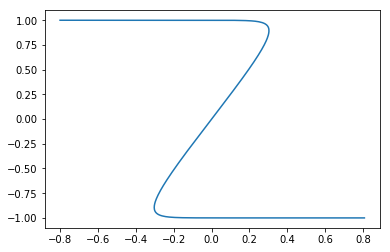

In [12]:

vos, lambdas = tuple(zip(*trace_conv_criterion.sol_arc))
plt.plot(lambdas, vos)
plt.show()